In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from pathlib import Path 
import tarfile 
import urllib.request




def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()# download the data

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


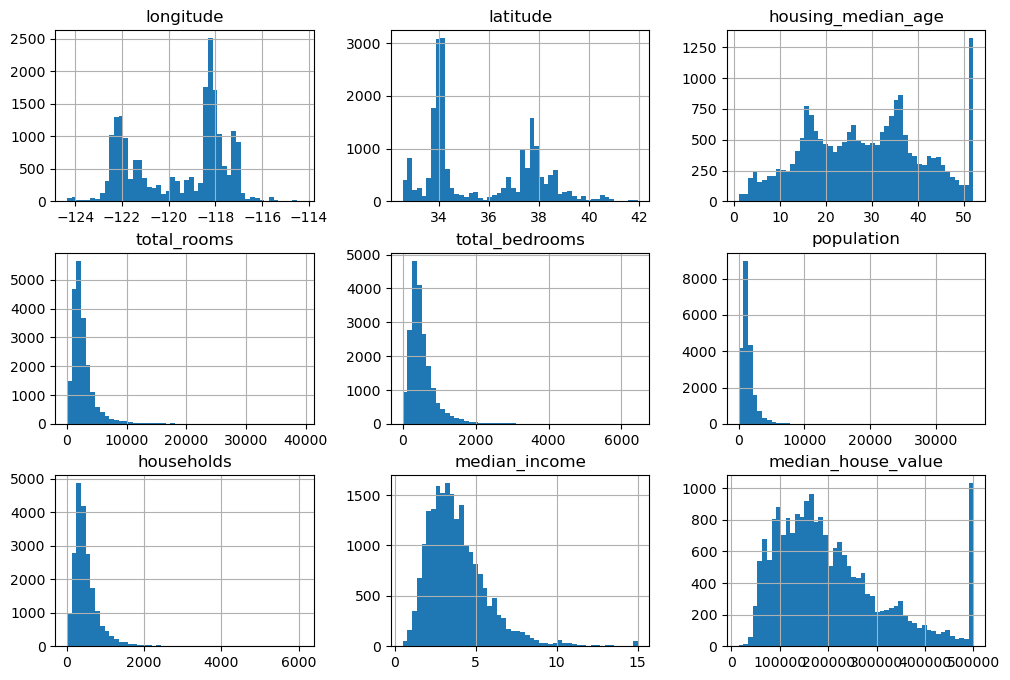

In [4]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size= 0.2, random_state= 42)

print(len(train_set + test_set))
print(len(housing))

20640
20640


In [6]:
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], 
                                labels=[1,2,3,4,5])


from sklearn.model_selection import StratifiedShuffleSplit


splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_split = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_split.append([strat_train_set_n, strat_test_set_n])
    

strat_train_set, strat_test_set = strat_split[0]

# or shorter by usin train_test_split
# strat_train_set, strat_test_set  = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state = 42)



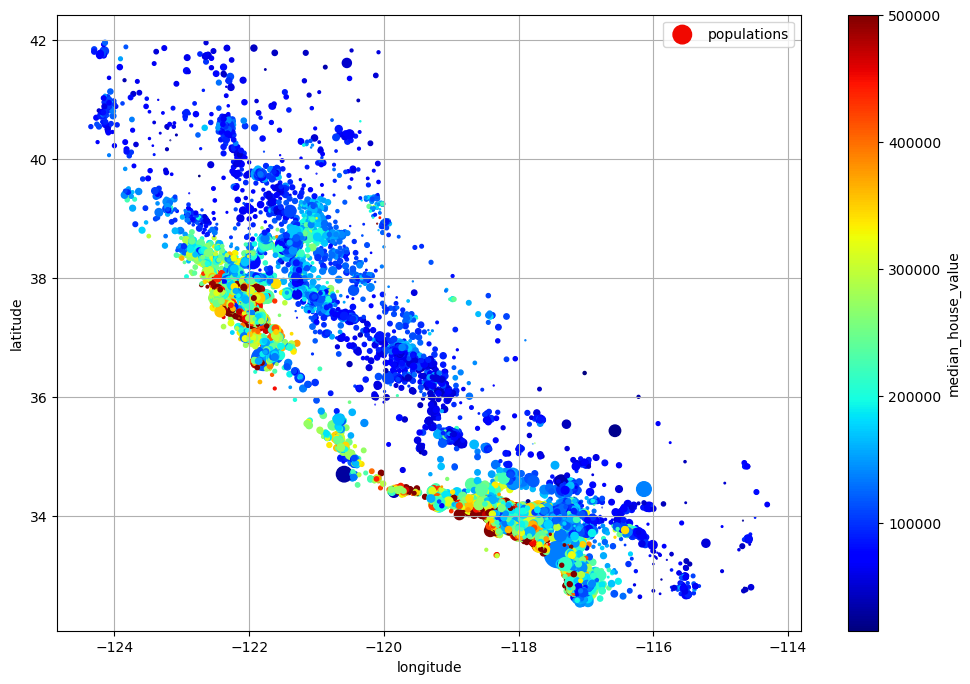

In [7]:
housing.plot(kind="scatter", x = "longitude", y="latitude", grid=True, 
             s = housing["population"]/100, label="populations",
             c = "median_house_value", cmap="jet", colorbar=True,
             legend=True,sharex=False,figsize=(12,8))
plt.show()

In [8]:
housing["population"]/100 # test 

0         3.22
1        24.01
2         4.96
3         5.58
4         5.65
         ...  
20635     8.45
20636     3.56
20637    10.07
20638     7.41
20639    13.87
Name: population, Length: 20640, dtype: float64

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


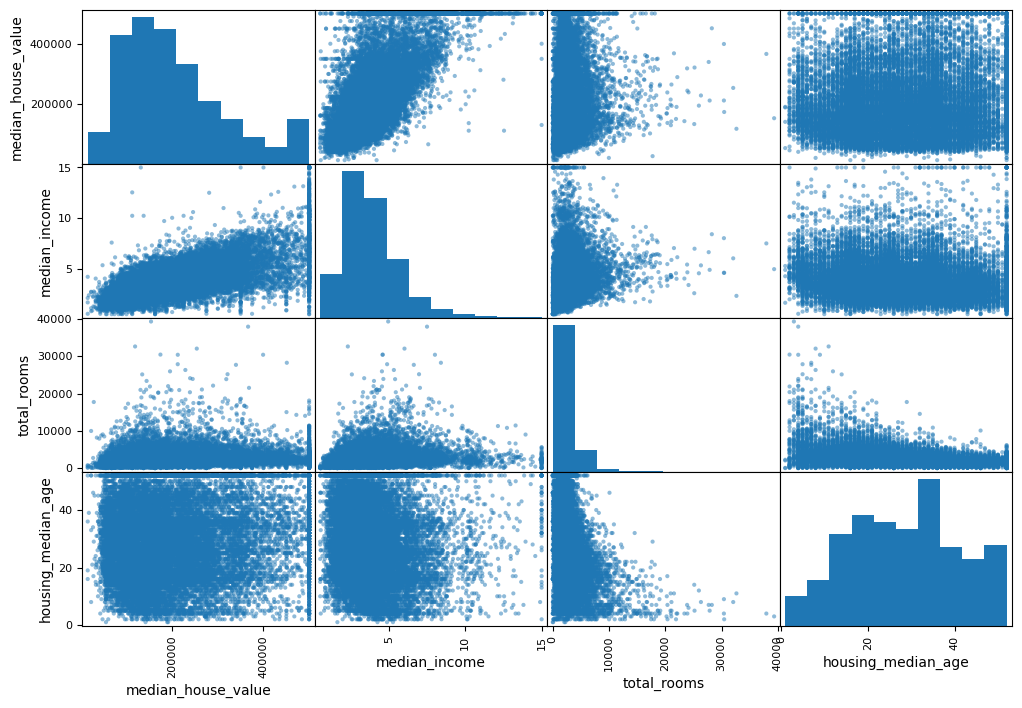

In [9]:
corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))


# or using scatter_matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()


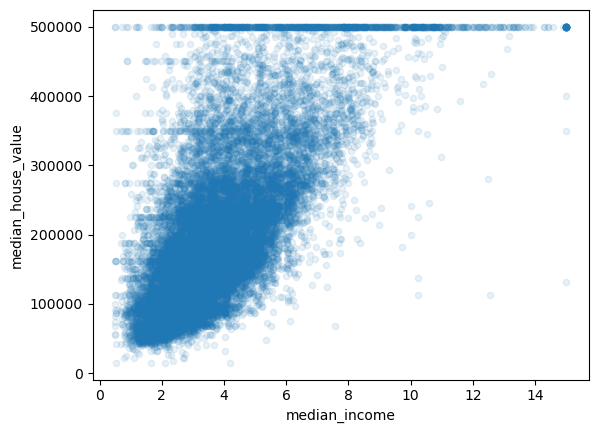

In [10]:
# the most correlation here we can see is median_income and median_house_value 
# let take a closer look
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

In [11]:
# divide the train set to X and Y, housing is X and housing_label is Y
housing = strat_train_set.drop("median_house_value", axis=1) # this make housing don't have Y value
housing_label = strat_train_set["median_house_value"].copy()

### clean the data

In [12]:
# using pandas 
# options 1: get rid of the corresponding districts
# housing.dropna(subset=["total_bedrooms"], inplace=True)

# # options 2: get rid of the whole attribute =)) 
# housing.drop("total_bedrooms", axis=1)


# # options 3: set the missing value to some value like zero, mean, median, etc ... this is called IMPUTATION
# median_total_bedroom = housing["total_bedrooms"].median()
# housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median_total_bedroom)


In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")


In [14]:
housing_num = housing.select_dtypes(include=[np.number]) # this only take the numeric attribute
 
imputer.fit(housing_num) # this imputer computed the median of each attrs and stored them in statistics_ instance

print(imputer.statistics_)
# compare to 
print(housing_num.median().values)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [15]:
# transform the training set 
X = imputer.transform(housing_num) # this output is either numpy arrray or scipy arrap

In [16]:
# let wrap it into a dataframe again 
housing_transformed = pd.DataFrame(X, columns=housing_num.columns, index = housing_num.index)

#### handle text data

In [17]:
# handle text attribute
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [18]:
# we can use sklearn OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [19]:
# get the list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [20]:
# because machine learning model could misunderstand about the distance between the number of ordinal 
# encoder so we need to use another 

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

print(housing_cat_1hot[:5])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (5, 5)>
  Coords	Values
  (0, 3)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 4)	1.0


In [21]:
# onehotencoder convert it in to sparse array 
# convert it in to numpy array
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [22]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature Scaling

In [23]:
# using Min Max Scale (normalization) 
# very sensitive with outliers
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range= (-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)


In [24]:
# using Standardization (z-score normalization) make mean = 0 and std = 1
# not sentitive with outliers
# work very well with gaussian distribution
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)




#### RBF

In [25]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

when u scaled the training data and then use the model to predict it
the prediction also scaled 
so you need to inverse the transform of the prediction

In [26]:

from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_label.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [27]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

we can use TransformedTargetRegressor
it is a meta-estimator, it is wrapper, wrap around a model

In [28]:
# this is better way cause sometimes you could forget to inverse the scaled

from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_label.to_frame()) # the parameter provided is not in scale

predictions = model.predict(some_new_data)

In [29]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

# Custom Transformers

In [30]:
# using FunctionTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# create my custom transformer
# np.log = logarit tu nhien co so e, np.exp = luy thua co so e
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

# apply transformer
log_pop = log_transformer.transform(housing[["population"]])

In [31]:
log_pop.head()

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905


In [32]:
# advanced FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args = dict(Y=[[35.]], gamma=0.1))
# kw_args 'keyword arguments' it pass the parameter has name to rbf_kernel 
# there is no inverse_func because rbf_kernel is one way transform 

age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [33]:
# another example of using kw_args
# measure the commonality of distance of sanfrancisco
sf_coords = 37.7749, -122.41 # this is a tuple 

sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1)) # we surround the sf_coords by [] to make it become a list
# notice: rbf_kernel can work on multi-dimensional like 2d or 3d ...

sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [34]:
# you could use it with lambda function 
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])

# example data
data = np.array([[1., 2.], [3., 4.]])

ratio_transformer.transform(data)

array([[0.5 ],
       [0.75]])

because FunctionTransformer is Stateless so to fix it we can custom our tranformer class 
by 
- BaseEstimator
- TransformerMixin



In [35]:
# create StandardScaler Clone =)) 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True): # there is no *arg or **kwargs
        self.with_mean = with_mean
        
    def fit(self, X, y=None): # here y is require even through z-score doesn't require
        X = check_array(X) # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self # always return self
    
    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (with trailing __)
        X = check_array(X)
        assert self.n_features_in == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_


in this example we combine KMean and rbf to create new feature 


In [36]:
# another example of using base estimator and transformermixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=0.1, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

        
    def get_feature_names_out(self, names=None):
        return [f"Cluster{i} similarity" for i in range(self.n_clusters)]

In [37]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_label)

In [38]:
similarities[:3].round(2)

array([[0.02, 1.  , 0.19, 0.01, 0.5 , 0.41, 0.81, 0.94, 0.05, 0.94],
       [0.96, 0.06, 0.8 , 0.72, 0.  , 0.44, 0.07, 0.02, 1.  , 0.11],
       [0.02, 0.96, 0.16, 0.  , 0.63, 0.44, 0.93, 0.95, 0.04, 0.88]])

# Transformation Pipelines